Math087 - Mathematical Modeling
===============================
[Tufts University](http://www.tufts.edu) -- [Department of Math](http://math.tufts.edu)  
[George McNinch](http://gmcninch.math.tufts.edu) <george.mcninch@tufts.edu>  
*Fall 2020*

Course material (Week 5): Integer programming via Branch & Bound
----------------------------------------------------------------

Integer programming: summary of some issue(s)
---------------------------------------------


As an example, consider the linear program:

``maximize`` $f(x_1,x_2) = x_1 + 5x_2$; i.e. $\mathbf{c} \cdot \mathbf{x}$ where $\mathbf{c} = \begin{bmatrix} 1 & 5 \end{bmatrix}$.

such that $A \mathbf{x} = \begin{bmatrix} 1 & 10 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \le
\begin{bmatrix} 20 \\ 2 \end{bmatrix}$ and $\mathbf{x} \ge \mathbf{0}$.

Let's find the optimal solution $\mathbf{x} \in \mathbb{R}^2$, and the optimal *integral* solution
$\mathbf{x}$ with $x_1,x_2 \in \mathbb{Z}$.

We'll start by solving the *relaxed* problem, where the integrality condition is ignored:

In [1]:
from scipy.optimize import linprog
import numpy as np

A = np.array([[1,10],[1,0]])
b = np.array([20,2])
c = np.array([1,5])

result=linprog((-1)*c,A_ub = A, b_ub = b)
print(f"result = {result.x}\nmaxvalue = {(-1)*result.fun:.2f}")

result = [2.  1.8]
maxvalue = 11.00


This calculution shows that an optimal solution with no integer constraint is $\mathbf{x} = \begin{bmatrix} 2 \\ 1.8 \end{bmatrix}$ and that the optimal value is roughly 11.


Let's make an image of the feasible set:

In [2]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

plt.rcParams.update({'font.size': 17})

# plot the feasible region
d = np.linspace(-.5,3,500)
X,Y = np.meshgrid(d,d)

def vector_le(b,c):
    return np.logical_and.reduce(b<=c)

@np.vectorize
def feasible(x,y):
    p=np.array([x,y])
    if vector_le(A@p,b) and vector_le(np.zeros(2),p):
        return 1.0
    else:
        return 0.0
               
Z=feasible(X,Y)


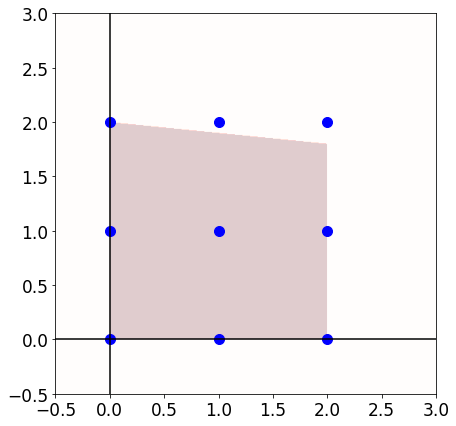

In [3]:

fig,ax = plt.subplots(figsize=(7,7))
ax.axhline(y=0, color = "black")
ax.axvline(x=0, color = "black")

# draw the region defind by x >= 0 and Ax <= b. 
ax.imshow(Z,
          extent=(X.min(),X.max(),Y.min(),Y.max()),
          origin="lower", 
          cmap="Reds", 
          alpha = 0.2)

def dot(x,y):
    return ax.scatter(x,y,s=100,color="blue")

# draw the integer points
for i,j in itertools.product(range(3),range(3)):
    dot(i,j)


You might imagine that the optimal *integer* solution is just obtained by rounding. Note the following:

$(2,2)$ is infeasible.

$(2,1)$ is feasible and $f(2,1) = 2 + 5\cdot 1 = 7$

$(1,2)$ is infeasible

$(1,1)$ is feasible and $f(1,1) = 1 + 5 \cdot 1 = 6$

But as it turns out, the optimal integer solution is the point $(0,2)$ for which $f(0,2) = 0 + 5 \cdot 2 = 10$.

Of course, this optimal integral solution is nowhere near the optimal non-integral solution. So in general, rounding is inadequate!

-------

How to proceed? Well, in this case there are not very many integral feasible points, so to optimize, we can just check the value of $f$ at all such points!

Consider a linear program in standard form for $\mathbf{x} \in \mathbb{R}^n$ with $\mathbf{x} \ge \mathbf{0}$, with inequality constraint $A \mathbf{x} \le \mathbf{b}$ which seeks to ``maximize`` its objective function $f$.



Here is a systematic way that we might proceed:

Find an integer $M \ge 0$ with the property that $$\mathbf{x} > M \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \implies \text{$\mathbf{x}$ is infeasible}.$$

There are $(M+1)^n$ points $\mathbf{x}$ with integer coordinates for which $\mathbf{0} \le \mathbf{x} \le M \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}$.

For each of these points $\mathbf{x}$, we do the following:
- if $\mathbf{x}$ is infeasible, discard
- otherwise, record the pair $(\mathbf{x},f(\mathbf{x}))$.

When we are finished, we just scan the list of recorded pairs and select that with  the largest objective function value; this selection solves the problem.



The strategy just described is systematic, easy to describe, and works OK when $(M+1)^n$ isn't so large. But e.g. if $M = 3$ and $n=20$, then already
$$(M+1)^n \approx 1.1 \times 10^{12},$$ 
which gives us a huge number of points to check!!!

A more systematic approach: "Branch & Bound"
============================================

We are going to describe an algorithm that implements a [branch-and-bound strategy](https://en.wikipedia.org/wiki/Branch_and_bound) to approach the problem described above.

Let's fix some notation; after we formulate some generalities, we'll specialize our treatment to some examples.



Notation
--------

We consider a ``integer linear program``:

$(\clubsuit)$ ``maximize`` $f(\mathbf{x}) = \mathbf{c}\cdot \mathbf{x}$

subject to:

- $\mathbf{x} \in \mathbb{Z}^n, \mathbf{x} \ge \mathbf{0}$ 
- $A \mathbf{x} \le \mathbf{b}$ for some $A \in \mathbb{R}^{r \times n}$ and $\mathbf{b} \in \mathbb{R}^r$.

Recall that $\mathbb{Z} = \{0, \pm 1, \pm 2, \cdots\}$ is the set of *integers*, and  $\mathbb{Z}^n$ is the just the set of vectors $\begin{bmatrix} a_1 & a_2 & \cdots & a_n \end{bmatrix}^T$ where $a_1,a_2, \dots, a_n \in \mathbb{Z}$.



We are going to suppose that we have some vector 

$$\mathbf{M} = \begin{bmatrix} m_1 & m_2 & \cdots & m_n \end{bmatrix}^T \in \mathbb{Z}^n, \quad \mathbf{M} \ge \mathbf{0}$$ 

with the property that $\mathbf{x} > \mathbf{M} \implies \mathbf{x}$ is infeasible (i.e. $\mathbf{x} > \mathbf{M} \implies A \mathbf{x} > \mathbf{b}$).

In practice, it'll often be the case that $m_1 = m_2 = \cdots = m_n$ but that isn't a requirement for us.

Let's write

$$S = \{ \mathbf{x} \in \mathbb{Z}^n \mid \mathbf{0} \le \mathbf{x} \le \mathbf{M} \}.$$ 

Note that the number of elements $|S|$ in the set $S$ is given by the product 
$$S = \prod_{i=1}^n (m_i + 1) = (m_1 + 1) \times (m_2 + 1) \times \cdots \times (m_n + 1).$$


And according to our assumption, $S$ contains every feasible point $\mathbf{x}$ whose coordinates are integers. So a brute force approach to finding an optimal integral point $\mathbf{x}$ could
be achieved just by testing each element of $S$.

Our goal is to systematically eliminate many of the points in $S$.

Algorithm overview
------------------

Keep the preceding notations. We sometimes refer to the entries $x_i$ of $\mathbf{x}$ as "variables".

Let's focus on one entry of $\mathbf{x} = \begin{bmatrix} x_1 & x_2 & \cdots & x_n \end{bmatrix}^T \in \mathbb{Z}^n$, say the $j$-th entry for some $1 \le j \le n$ (we'll say more below about how we should select $j$).  i.e. we focus on the variable $x_j$.

Now, $x_j$ may take the values $0,1,2,\cdots,m_j$, so we consider
the following subsets of $S$:

$$\begin{matrix} 
S_0 &=& \{\mathbf{x} \in S \mid x_j = 0\} \\
S_1 &=& \{\mathbf{x} \in S \mid x_j = 1\} \\
\vdots & \vdots & \vdots \\
S_{m_j} & = & \{\mathbf{x} \in S \mid x_j = m_j\}
\end{matrix}$$
 
Thus we have *partitioned* $S$ as a *disjoint union* of certain subsets:

$$S = S_0 \cup S_1 \cup \cdots \cup S_{m_j}$$



For $0 \le \ell \le m_j$, write $f_\ell$ for the maximum value of the objective function on points in $S_\ell$:

$$f_\ell = \max\left(f(\mathbf{x}) = \mathbf{c} \cdot \mathbf{x} \mid \mathbf{x} \in S_\ell\right ).$$

If we know for some $\ell_0$ that the quantity $f_{\ell_0}$ exceeds $f_\ell$ for every $\ell \not = \ell_0$, then of course an optimal integral 
to $(\clubsuit)$ is contained in the subset $S_{\ell_0}$.

So we can then *prune* all the $S_\ell$ with $\ell \not = \ell_0$ and continue our search for optimal solutions to $(\clubsuit)$ only considering points in $S_{\ell_0}$.

We may now *repeat* the above procedure by focusing on a *new entry of $\mathbf{x}$* (different from the $j$-th entry), checking only points in $S_{\ell_0}$.

Iterating after selection of the subset $S_{\ell_0}$ is known as *branching*.

The main question now is this: how can we compare the values $f_\ell, 0 \le \ell \le m_j$ with one another, in order to carry out our pruning? This is known as *bounding*; so the question is: "how do we bound"?

The answer is to use "relaxed" versions of the integer linear program $(\clubsuit)$, obtained by omitting variables (imposing additional equality constraints) and/or eliminating the "integral" requirement.

E.g. using ordinary linear programming, we may find the optimal *value* $v_\ell$ of the objective function for the linear program obtained from $(\clubsuit)$ by considering $\mathbf{x} \in \mathbb{R}^n$ rather than $\in \mathbb{Z}^n$ and
by imposing the additional equality constraint $x_j = \ell$.

Then of course $f_\ell \le v_\ell$ -- i.e. $v_\ell$ is an *upper bound* for $f_\ell$.

On the other hand, for any point $\mathbf{\widetilde x} \in S_\ell$, the must have 
$$f(\widetilde x) = \mathbf{c} \cdot \mathbf{\widetilde x} \le f_\ell$$
(since $f_\ell$ is the maximum of such values!).

These observations give us access to upper and lower bounds for the $f_\ell$; we can now *bound* - i.e. prune - $S_\ell$ if we can demonstrate that a lower bound for $f_{\ell_0}$ exceeds an upper bound for $f_\ell$
for $\ell \not = \ell_0$.


Example
-------------------

Let's see how this works in practice!

As a guiding heuristic, when we have a (non-integral) optimal point for a linear program, we choose
to branch on the variable whose value (for this optimal point) is non-integral but closest to a integer.

Consider again  the integer linear program

$(\diamondsuit) \quad $ ``maximize`` $f(x_1,x_2) = x_1 + 5x_2$; i.e. $\mathbf{c} \cdot \mathbf{x}$ where $\mathbf{c} = \begin{bmatrix} 1 & 5 \end{bmatrix}$.

such that $A \mathbf{x} = \begin{bmatrix} 1 & 10 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \le
\begin{bmatrix} 20 \\ 2 \end{bmatrix}$ and $\mathbf{x} \ge \mathbf{0}$ for $\mathbf{x} \in \mathbb{Z}^2$.

We notice that $(*) \quad \mathbf{x} > \begin{bmatrix} 2 & 2 \end{bmatrix}^T \implies \mathbf{x}$ is not feasible.

To begin, we first solve the linear program obtained from $(\diamondsuit)$ by consider $\mathbf{x} \in \mathbb{R}^2$. The optimal value is $v = 11$ and an optimal solution is $\mathbf{x} = (2,1.8)$.

Thus for this optimal solution, $x_1$ is already an integer, so we branch on $x_2$.




According to $(*)$, $x_2$ can take the values $0,1,2$; we consider these cases in turn:

- $x_2 = 0$

  We solve the linear program obtained from $(\diamondsuit)$ be considering 
  $\mathbf{x} \in \mathbb{R}^2$ and by imposing the additional equality constraint $x_2 = 0$;
  the optimal value is $v_0 = 2$ and 
  an optimal solution is $\mathbf{x} = (2,0)$.
  
- $x_2 = 1$

  We solve the linear program obtained from $(\diamondsuit)$ be considering 
  $\mathbf{x} \in \mathbb{R}^2$ and by imposing the additional equality constraint $x_2 = 1$;
  the optimal value is $v_1 = 7$ and 
  an optimal solution is $\mathbf{x} = (2,1)$.
  
- $x_2 = 2$

  We solve the linear program obtained from $(\diamondsuit)$ be considering 
  $\mathbf{x} \in \mathbb{R}^2$ and by imposing the additional equality constraint $x_2 = 2$;
  the optimal value is $v_2 = 10$ and 
  an optimal solution is $\mathbf{x} = (0,2)$.
  



We also see that $f_0 \le 2, f_1 \le 7$ and (since $(0,2)$ is an integral solution) $10 \le f_2$;
thus $f_2$ exceeds $f_0$ and $f_1$. Thus we ``prune`` $S_0$ and $S_1$.

Moreover, 
since the optimal solution $v_2$ is actually integral, we find $f_2 = v_2$.

Thus $f_2 = 10$ is the optimal value for $(\diamondsuit)$ and an optimal integral solution is $\mathbf{x} = (x_1,x_2) = (0,2)$.


One often presents this algorithm via a tree diagram, like the following:

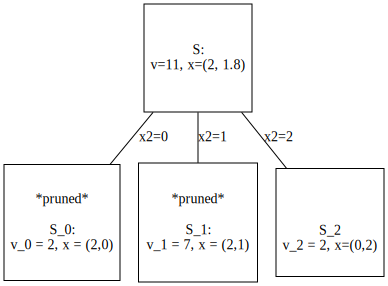

In [4]:
from graphviz import Graph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Graph('bb1')

dot.node('S','S:\nv=11, x=(2, 1.8)',shape="square")

dot.node('S0','*pruned*\n\nS_0:\nv_0 = 2, x = (2,0)',shape="square")
dot.node('S1','*pruned*\n\nS_1:\nv_1 = 7, x = (2,1) ',shape="square")
dot.node('S2','\n\nS_2\nv_2 = 2, x=(0,2)',shape="square")


dot.edge('S','S0','x2=0')
dot.edge('S','S1','x2=1')
dot.edge('S','S2','x2=2')

dot

--------------------
Now let's consider a more elaborate example.

Example
=======

$(\heartsuit) \quad $ ``maximize`` $f(\mathbf{x}) = \begin{bmatrix} 10 & 7 & 4 & 3 & 1 & 0 \end{bmatrix} \cdot \mathbf{x}$

subject to: $\mathbf{x} = \begin{bmatrix} x_1 & x_2 & x_3 & x_4 &x_5 & x_6 \end{bmatrix}^T \in \mathbb{R}^5$, $\mathbf{x} \ge \mathbf{0}$, 

$x_1,x_2,x_3,x_4,x_5 \in \{0,1\}$

and $A \mathbf{x} \le \mathbf{b}$

where $A = \begin{bmatrix}
 2 & 6 & 1 & 0 & 0 & 1 \\
 1 & 0 & 2 & -3 & 1 & -1 \\
 2 & -3 & 4 & 1 & 1 & 0 \\
 1 & 1 & 1 & 1 & -1 & 0  \\
\end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix}
7 \\ -1 \\ 3 \\ 3
\end{bmatrix}.$


Notice that we *aren't* imposing any integral condition on $x_6$, but we require that $x_i \in \mathbb{Z}$ for $1 \le i \le 5$, and even more: these coordinates may only take the value $0$ or $1$.

The procedure described above can (with perhaps some minor adaptations) be applied to this problem, as we now describe. Note that -- unlike the previous example -- we now must iterate our procedure. 


**(A)** 

We begin by finding an optimal solution to the linear program obtained from $(\heartsuit)$ by replacing
the condition 

$x_1,x_2,x_3,x_4,x_5 \in \{0,1\}$
with the condition $\begin{bmatrix} x_1 & x_2 & x_3 & x_4 &x_5 \end{bmatrix}^T \le \begin{bmatrix} 1 & 1 & 1 & 1 & 1\end{bmatrix}$ 

(note that the variables are already required to be non-negative by other conditions in $(\heartsuit)$).

The optimal value of the objective function is $v_A=20.21$ and an optimal solution is 
$\mathbf{x}_A = (1,0.72,0.49,1,0.21,0.19)$

Of the non-integer coordinates of $\mathbf{x}^*$, the one closest to an integer is $x_5 =.21$.

**Branch on (A)** with $x_5$:



**(B)**:  branching from **(A)** with $x_5 = 0$ 

Find an optimal solution to the linear program of **(A)** with the
additional equality constraint $x_5 = 0$. The optimal value is $v_B=19.44$
and an optimal solution is $\mathbf{x}_B = (1.00, 0.78, 0.33, 0.89, 0.00,
0.00)$.

**(C)**: branching from **(A)** with $x_5 = 1$

Find an optimal solution to the linear program of **(A)** with the
additional equality constraint $x_5 = 1$. The optimal value is $v_C=19.97$
and an optimal solution is $\mathbf{x}_C = (1.00, 0.70, 0.27, 1.00, 1.00, 0.55)$.

We must now branch off of both **(B)** and **(C)**. We'll begin with **(C)**, and branch 
on $x_3$:

**(D)**: branching from **(C)** with $x_3 = 0$.

Find an optimal solution to the linear program of **(C)** with 
equality constraints $x_5=1$, $x_3 = 0$. The optimal value is $v_D=19.83$
and an optimal solution is $\mathbf{x}_D = (1.00, 0.83, 0.00, 1.00, 1.00, 0.00)$.

**(E)**: branching from **(C*)** with $x_3=1$.

We try to find an optimal solution to the linear program of **(C)** with
equality constraints $x_5=1$, $x_3 = 1$. But there are no feasible points.

So we may **Prune** **(E)**.


We now branch on **(D)** with $x_2$.

**(F)**: branching from **(D)** with $x_2 = 0$.

Find an optimal solution to the linear program of **(D)** with 
equality constraints $x_5=1$, $x_3 = 0$, $x_2 = 0$. The optimal value is $v_F=11.0$
and an optimal solution is $\mathbf{x}_F = (1.00, 0.00, 0.00, 0.00, 1.00, 3.92)$.

Observe that $\mathbf{x}_F$ is an integral solution (we have no integrality requirement for $x_6$) so we can stop examining this branch of the tree.

**(G)**: branching from **(D)** with $x_2 = 1$.

Find an optimal solution to the linear program of **(D)** with
equality constraints $x_5=1$, $x_3 = 0$, $x_2 = 1$. The optimal value is $v_G=16$
and an optimal solution is $\mathbf{x}_G = (0.50, 1.00, 0.00, 1.00, 1.00, 0.00)$



We are now done branching "below **(C)**", and so we return and **branch on (B)** with $x_4$:

**(H)**: branching from **(B)** with $x_4 = 0$.

Find an optimal solution to the linear program of **(B)** with
equality constraints $x_5=0$, $x_4 = 0$. The optimal value is $v_H=13.73$
and an optimal solution is $\mathbf{x}_H = (1.00, 0.27, 0.45, 0.00, 0.00, 2.91)$


**(I)**: branching from **(B)** with $x_4 = 1$.

Find an optimal solution to the linear program of **(B)** with
equality constraint $x_5=0$, $x_4 = 1$. The optimal value is $v_I=19.4$
and an optimal solution is $\mathbf{x}_I = (1.00, 0.80, 0.20, 1.00, 0.00, 0.00)$



Now **branch on (I)** with $x_2$:

**(J)**: branching from **(I)** with $x_2=0$.

Find an optimal solution to the linear program of **(I)** with 
equality constraints $x_5=0$, $x_4 = 1$, $x_2 = 0$. The optimal value is $v_J=13$
and an optimal solution is $\mathbf{x}_J = (1.00, 0.00, 0.00, 1.00, 0.00, 2.26)$

This is an integer point, and $13$ is larger than the objective function value for the point from **(F)**,
so we **Prune (F)**.

**(K)**: branching from **(I)** with $x_2=1$.

Find an optimal solution to the linear program of **(I)** with
equality constraints $x_5=0$, $x_4 = 1$, $x_2 = 1$. The optimal value is $v_K=15$
and an optimal solution is $\mathbf{x}_K = (0.50, 1.00, 0.00, 1.00, 0.00, 0.00)$



Now **branch from (G)** with $x_1$:

**(L)**: branching from **(G)** with $x_1=0$


Find an optimal solution to the linear program of **(G)** with
equality constraints $x_5=1$, $x_3 = 0$, $x_2 = 1$, $x_1 = 0$. The optimal value is $v_L=11$
and an optimal solution is $\mathbf{x}_L = (0.00, 1.00, 0.00, 1.00, 1.00, 0.53)$

This is an integer solution **prune (L)** since the integer solution from **(J)** has an larger  objective function value than 11.

**(M)**: branching from **(G)** with $x_1=1$


Try to find an optimal solution to the linear program of **(G)** with
equality constraints $x_5=1$, $x_3 = 0$, $x_2 = 1$, $x_1 = 1$. This linear program is infeasible.





Finally, **branch from (K)** with $x_1$

**(N)**: branching from **(K)** with $x_1=0$


Find an optimal solution to the linear program of **(K)** with
equality constraints $x_5=0$, $x_4 = 1$, $x_2 = 1$, $x_1 = 0$. The optimal value is $v_N=14$ 
and an optimal solution is $\mathbf{x}_N = (0.00, 1.00, 1.00, 1.00, 0.00, 0.00)$

This is an integer solution.

**(O)**: branching from **(K)** with $x_1=1$

Try to find an optimal solution to the linear program of **(K)** with 
equality constraints $x_5=0$, $x_4 = 1$, $x_2 = 1$, $x_1 = 1$. This linear program is infeasible.

Finally,we **Prune (H) and (J)** since the objective function for the point in **(N)** exceeds an upper bound for the objective functions in **(H)** and in **(J)**. 

We are now **finished**; the integer point $\mathbf{x}_N = (0.00, 1.00, 1.00, 1.00, 0.00, 0.00)$ with $v_N = 14$
is an optimal point for $(\heartsuit)$.

-------------

We have included below ``python`` code used to find the optimal solutions/values given in **(A)--(O)**. 
Before giving that code, we also construct (via ``graphviz``) the *tree* corresponding to the branch-and-bound just carried out; see below.


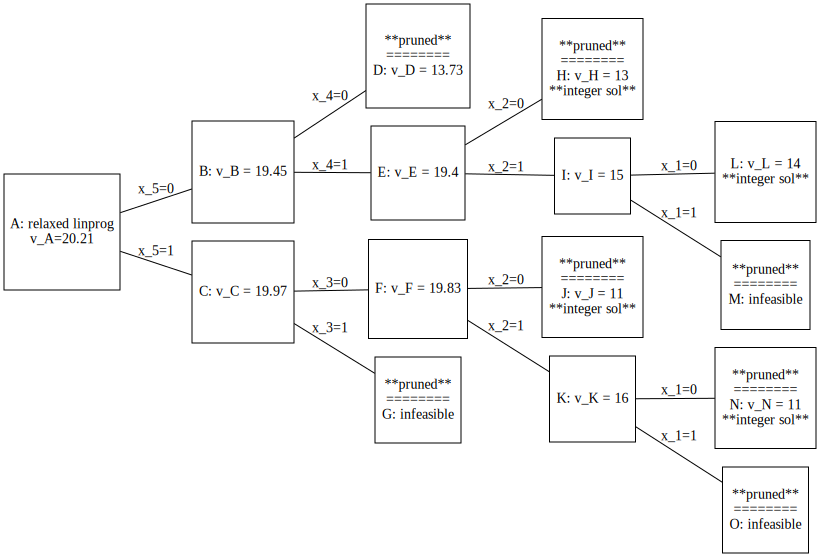

In [5]:
from graphviz import Graph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Graph('bb1')
dot.attr(rankdir='LR')
dot.node('A','A: relaxed linprog\nv_A=20.21',shape="square")

dot.node('B','B: v_B = 19.45',shape="square")
dot.node('C','C: v_C = 19.97',shape="square")
dot.node('D','**pruned**\n========\nD: v_D = 13.73',shape="square")
dot.node('E','E: v_E = 19.4',shape="square")
dot.node('F','F: v_F = 19.83',shape="square")
dot.node('G','**pruned**\n========\nG: infeasible',shape="square")
dot.node('H','**pruned**\n========\nH: v_H = 13\n**integer sol**',shape="square")
dot.node('I','I: v_I = 15',shape="square")
dot.node('J','**pruned**\n========\nJ: v_J = 11\n**integer sol**',shape="square")
dot.node('K','K: v_K = 16',shape="square")
dot.node('L','L: v_L = 14\n**integer sol**',shape="square")
dot.node('M','**pruned**\n========\nM: infeasible',shape="square")
dot.node('N','**pruned**\n========\nN: v_N = 11\n**integer sol**',shape="square")
dot.node('O','**pruned**\n========\nO: infeasible',shape="square")


dot.edge('A','B','x_5=0')
dot.edge('A','C','x_5=1')

dot.edge('B','D','x_4=0')
dot.edge('B','E','x_4=1')

dot.edge('C','F','x_3=0')
dot.edge('C','G','x_3=1')

dot.edge('E','H','x_2=0')
dot.edge('E','I','x_2=1')

dot.edge('F','J','x_2=0')
dot.edge('F','K','x_2=1')

dot.edge('I','L','x_1=0')
dot.edge('I','M','x_1=1')


dot.edge('K','N','x_1=0')
dot.edge('K','O','x_1=1')



dot

In [6]:
import numpy as np
from scipy.optimize import linprog

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

def sbv(index,size):
    return np.array([1.0 if i == index-1 else 0.0 for i in range(size)])

def eq_coords(idx,size):
    return np.array([sbv(i,size) for i in idx])

A = np.array([[2,6,1,0,0,1],[1,0,2,-3,1,-1],[2,-3,4,1,1,0],[1,1,1,1,-1,0]])
b = np.array([7,-1,3,3])
c = np.array([10,7,4,3,1,0])

bb = 5*[(0,1)] + [(0,None)]

resA = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb)
resB = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=np.array([sbv(5,6)]),b_eq=0)
resC = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=np.array([sbv(5,6)]),b_eq=1)

resD = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,3],6),b_eq=np.array([1,0]))
resE = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,3],6),b_eq=np.array([1,1]))

resF = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,3,2],6),b_eq=np.array([1,0,0]))
resG = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,3,2],6),b_eq=np.array([1,0,1]))

resH = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,4],6),b_eq=np.array([0,0]))
resI = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,4],6),b_eq=np.array([0,1]))

resJ = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,4,2],6),b_eq=np.array([0,1,0]))
resK = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,4,2],6),b_eq=np.array([0,1,1]))


resL = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,3,2,1],6),b_eq=np.array([1,0,1,0]))
resM = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,3,2,1],6),b_eq=np.array([1,0,1,1]))


resN = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,4,2,1],6),b_eq=np.array([0,1,1,0]))
resO = linprog((-1)*c,A_ub=A,b_ub=b,bounds=bb,A_eq=eq_coords([5,4,2,1],6),b_eq=np.array([0,1,1,1]))


def report(res):
    return f"OK? {str(res.success):6s}  opt value: {(-1)*res.fun:.2f}  opt point: {res.x}"

print("A - " + report(resA))
print("B - " + report(resB))
print("C - " + report(resC))
print("D - " + report(resD))
print("E - " + report(resE))
print("F - " + report(resF))
print("G - " + report(resG))
print("H - " + report(resH))
print("I - " + report(resI))
print("J - " + report(resJ))
print("K - " + report(resK))
print("L - " + report(resL))
print("M - " + report(resM))
print("N - " + report(resN))
print("O - " + report(resO))


A - OK? True    opt value: 20.21  opt point: [1.00 0.72 0.49 1.00 0.21 0.19]
B - OK? True    opt value: 19.44  opt point: [1.00 0.78 0.33 0.89 0.00 0.00]
C - OK? True    opt value: 19.97  opt point: [1.00 0.70 0.27 1.00 1.00 0.55]
D - OK? True    opt value: 19.83  opt point: [1.00 0.83 0.00 1.00 1.00 0.00]
E - OK? False   opt value: 13.62  opt point: [0.01 0.84 1.00 0.88 1.00 1.29]
F - OK? True    opt value: 11.00  opt point: [1.00 0.00 0.00 0.00 1.00 3.92]
G - OK? True    opt value: 16.00  opt point: [0.50 1.00 0.00 1.00 1.00 0.00]
H - OK? True    opt value: 13.73  opt point: [1.00 0.27 0.45 0.00 0.00 2.91]
I - OK? True    opt value: 19.40  opt point: [1.00 0.80 0.20 1.00 0.00 0.00]
J - OK? True    opt value: 13.00  opt point: [1.00 0.00 0.00 1.00 0.00 2.26]
K - OK? True    opt value: 15.00  opt point: [0.50 1.00 0.00 1.00 0.00 0.00]
L - OK? True    opt value: 11.00  opt point: [0.00 1.00 0.00 1.00 1.00 0.53]
M - OK? False   opt value: 22.23  opt point: [1.00 1.00 0.00 1.41 1.00 3.04]

Postcript
=========

It turns out that solving integer programming problems is *hard*. In fact, in computer
science integer programming problems are in a class of problems called [**NP Hard** problems](https://en.wikipedia.org/wiki/NP-completeness) -- see the [discussion here.](https://en.wikipedia.org/wiki/Integer_programming).

The algorithm we describe above is a type of ``branch and bound algorithm``, which is a common approach. While our description gives pretty good evidence that this approach is effective, we haven't said anything e.g. about the ``run time`` of our algorithm, etc.